# Live trade list quick PnL

Fill the variables below, then run.

rows: 38
portfolio_return: 0.0012532490886590754
return stats:
count    38.000000
mean      0.001253
std       0.011486
min      -0.029933
25%      -0.002052
50%      -0.000473
75%       0.002858
max       0.036376
Name: return, dtype: float64
all cbonds return stats:
count    379.000000
mean      -0.001908
std        0.020198
min       -0.144814
25%       -0.005862
50%       -0.001266
75%        0.001835
max        0.098550
dtype: float64
market_equal_weight_return: -0.001908015440565891


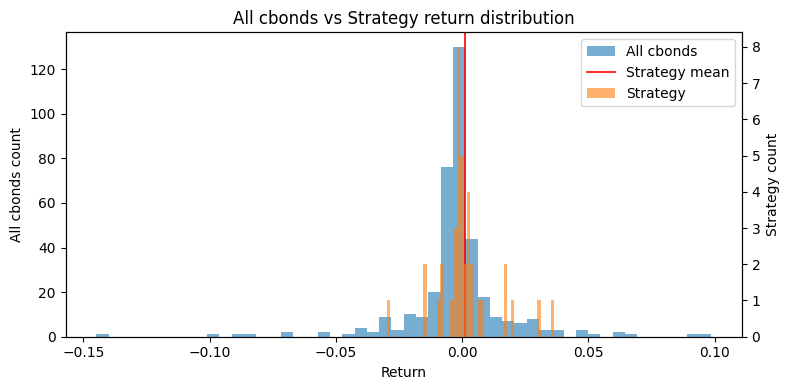

In [23]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ---- settings ----
trade_day = '2026-01-15'  # trade_list date
signal_name = 'combo_default'
batch_id = 'Live'
results_root = Path('D:/cbond_daily/results')
cleaned_root = Path('D:/cbond_daily/clean_data')

buy_twap_col = 'twap_0945_1000'
sell_twap_col = 'twap_1430_1442'
twap_bps = 1.5
fee_bps = 0.7

# ---- load trade list ----
trade_dir = results_root / 'live' / trade_day / batch_id / signal_name
trade_path = trade_dir / 'trade_list.csv'
trades = pd.read_csv(trade_path)
trades['trade_date'] = pd.to_datetime(trades['trade_date']).dt.date

# ---- load cleaned data for trade_day ----
day = pd.to_datetime(trade_day).date()
month = f'{day.year:04d}-{day.month:02d}'
cleaned_path = cleaned_root / month / f'{day:%Y%m%d}.parquet'
df = pd.read_parquet(cleaned_path)

# ---- merge and compute return ----
merged = trades.merge(df[['code', buy_twap_col, sell_twap_col]], on='code', how='left')

def apply_bps(px, bps, side):
    if side == 'buy':
        return px * (1 + bps / 10000.0)
    return px * (1 - bps / 10000.0)

cost_bps = twap_bps + fee_bps
buy_px = apply_bps(merged[buy_twap_col], cost_bps, 'buy')
sell_px = apply_bps(merged[sell_twap_col], cost_bps, 'sell')
merged['return'] = (sell_px - buy_px) / buy_px

# ---- summary ----
merged['weight'] = merged.get('weight', 1.0 / len(merged))
merged['weight'] = merged['weight'].fillna(0.0)
port_ret = float((merged['return'] * merged['weight']).sum())
print('rows:', len(merged))
print('portfolio_return:', port_ret)

# ---- per-stock stats ----
stats = merged['return'].describe()
print('return stats:')
print(stats)


# ---- all cbonds return distribution ----
all_df = df[['code', buy_twap_col, sell_twap_col]].copy()
all_df = all_df[
    all_df[buy_twap_col].notna()
    & all_df[sell_twap_col].notna()
    & (all_df[buy_twap_col] > 0)
    & (all_df[sell_twap_col] > 0)
]
all_buy = apply_bps(all_df[buy_twap_col], cost_bps, 'buy')
all_sell = apply_bps(all_df[sell_twap_col], cost_bps, 'sell')
all_returns = (all_sell - all_buy) / all_buy

print('all cbonds return stats:')
print(all_returns.describe())

# equal-weight market return (all tradable)
if len(all_returns) > 0:
    market_eq_ret = float(all_returns.mean())
    print('market_equal_weight_return:', market_eq_ret)

# histogram
fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()
ax.hist(all_returns.dropna(), bins=50, alpha=0.6, label='All cbonds')
ax2.hist(merged['return'].dropna(), bins=50, alpha=0.6, color='tab:orange', label='Strategy')
ax.axvline(merged['return'].mean(), color='red', linewidth=1.2, label='Strategy mean')
ax.set_title('All cbonds vs Strategy return distribution')
ax.set_xlabel('Return')
ax.set_ylabel('All cbonds count')
ax2.set_ylabel('Strategy count')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='best')
fig.tight_layout()
plt.show()



In [24]:
merged

,trade_date,code,weight,twap_0945_1000,twap_1430_1442,return
0,2026-01-15,111009.SH,0.026316,122.6111,122.5625,-0.000836
1,2026-01-15,111014.SH,0.026316,125.5402,125.6120,0.000132
2,2026-01-15,111018.SH,0.026316,130.5099,130.2895,-0.002128
3,2026-01-15,113048.SH,0.026316,126.6009,127.5117,0.006751
4,2026-01-15,113610.SH,0.026316,130.6109,130.6617,-0.000051
5,2026-01-15,113634.SH,0.026316,129.2424,129.6760,0.002914
6,2026-01-15,113636.SH,0.026316,126.4444,125.5465,-0.007538
7,2026-01-15,113661.SH,0.026316,134.9758,135.0339,-0.000010
8,2026-01-15,113671.SH,0.026316,142.4052,142.9494,0.003380
9,2026-01-15,113682.SH,0.026316,127.9226,128.1791,0.001564
